## Import packets

In [1]:
# import AP-GCN model
from APGCNmodel import APGCN

import time
import random
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
import torch.nn.functional as F
from torch.optim import Adam, Optimizer
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data, InMemoryDataset

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Dataset loader

In [2]:
# Dataset class: it allows to translate a vector (Graph, Attributes, Labels)
# into a dataset compatible with the PyTorch models.
# 
# Parameters:
# - G: NetworkX graph
# - Labels: of the nodes used for classification
# - attributes: List of the nodes' attributes

class MyDataset(InMemoryDataset):
  def __init__(self, G, labels, attributes = None, num_classes = 2):
    super(MyDataset, self).__init__('.', None, None, None)

    # import data from the networkx graph with the attributes of the nodes
    data = from_networkx(G, attributes)
      
    y = torch.from_numpy(labels).type(torch.long)

    data.x = data.x.float()
    data.y = y.clone().detach()
    data.num_classes = num_classes

    # Using train_test_split function from sklearn to stratify train/test/val sets
    indices = range(G.number_of_nodes())
    # Stratified split of train/test/val sets. Returned indices are used to create the masks
    X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(data.x, data.y, indices, test_size=0.3, stratify=labels, random_state=42)
    # To create validation set, test set is splitted in half
    X_test, X_val, y_test, y_val, test_idx, val_idx = train_test_split(X_test, y_test, test_idx, test_size=0.5, stratify=y_test, random_state=42)

    n_nodes = G.number_of_nodes()
    train_mask  = torch.zeros(n_nodes, dtype=torch.bool)
    test_mask   = torch.zeros(n_nodes, dtype=torch.bool)
    val_mask    = torch.zeros(n_nodes, dtype=torch.bool)

    for idx in train_idx:
      train_mask[idx] = True

    for idx in test_idx:
      test_mask[idx] = True
    
    for idx in val_idx:
      val_mask[idx] = True

    data['train_mask']  = train_mask
    data['test_mask']   = test_mask
    data['val_mask']    = val_mask

    self.data, self.slices = self.collate([data])

## Training Function

In [3]:
def summary(results):
    report={}
    for k, v in results.items():
        if k != 'steps' and k != 'probs':
            boots_series = sns.algorithms.bootstrap(results[k], func=np.mean, n_boot=1000)
            report[k] = np.mean(results[k])
            report[f'{k}_ci'] = np.max(np.abs(sns.utils.ci(boots_series, 95) - report[k]))
        else:
            array = np.array([k.mean().cpu().detach().numpy() for k in results['steps']])
            boots_series = sns.algorithms.bootstrap(array, func=np.mean, n_boot=1000)
            report[k] = np.mean(array)
            report[f'{k}_ci'] = np.max(np.abs(sns.utils.ci(boots_series, 95) - report[k]))
    return report

def plot_density(results):
    fig, ax = plt.subplots()

    z =[(x.cpu().numpy()).astype(int) for x in results['steps']]
    z = np.vstack(z)
    z = np.mean(z,axis=0)

    sns.distplot(z, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                 ax=ax)
    plt.xlabel('Number of Steps')
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()
    return

def train(model: torch.nn.Module, optimizer: Optimizer, data: Data, train_halt, weight_decay: float):
    model.train()
    
    for param in model.prop.parameters():
        param.requires_grad = train_halt

    optimizer.zero_grad()
    logits, steps, reminders = model(data)
    
    loss = F.nll_loss(logits[data.train_mask], data.y[data.train_mask])
    l2_reg = sum((torch.sum(param ** 2) for param in model.reg_params))
    loss += weight_decay/2 * l2_reg + model.prop_penalty *(
            steps[data.train_mask] + reminders[data.train_mask]).mean()
    
    loss.backward()
    optimizer.step()
    return logits

def evaluate(model: torch.nn.Module, data: Data, test: bool, weight_decay: float):
    model.eval()
    
    with torch.no_grad():
        logits, steps, reminders = model(data)
        
        loss = F.nll_loss(logits[data.train_mask], data.y[data.train_mask])
        l2_reg = sum((torch.sum(param ** 2) for param in model.reg_params))
        loss += weight_decay/2 * l2_reg + model.prop_penalty *(
                steps[data.train_mask] + reminders[data.train_mask]).mean()

    eval_dict = {}
    keys = ['train','val']
    eval_dict['steps'] = steps
    for key in keys:
        mask = data[f'{key}_mask']
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        eval_dict[f'{key}_acc'] = acc
    return eval_dict, loss


def test_acc(model: torch.nn.Module, data: Data):
    model.eval()
    
    with torch.no_grad():
        logits, steps, reminders = model(data)
    mask = data['test_mask']
    pred = logits[mask].max(1)[1]
    acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
    return acc

def run(model, dataset, lr=0.01, test=False, patience=100, max_epochs=1000, weight_decay=0.01):
    logits = None
    best_dict = defaultdict(list)

    # model = model.reset_parameters()
    optimizer = Adam(model.parameters(),lr=lr)

    patience_counter = 0
    best_loss = 999
    tmp_dict = {'val_acc': 0}

    start_time = time.perf_counter()
    for epoch in tqdm(range(1, max_epochs + 1)):
        if patience_counter == patience:
            break

        logits = train(model, optimizer, dataset.data.to(device), epoch%5==0, weight_decay)
        eval_dict, loss = evaluate(model, dataset.data, test, weight_decay)
                        
        if(eval_dict['val_acc'] > tmp_dict['val_acc']) or (
            (eval_dict['val_acc'] == tmp_dict['val_acc']) and loss < best_loss):
            patience_counter = 0
            tmp_dict['epoch'] = epoch
            tmp_dict['runtime'] = time.perf_counter() - start_time
            
            for k, v in eval_dict.items():
                tmp_dict[k] = v

            best_state = {key: value.cpu() for key, value
                                in model.state_dict().items()}
        
        else:
            patience_counter += 1
            
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
                    
    model.load_state_dict(best_state)

    tmp_dict['test_acc'] = test_acc(model,dataset.data)
    print("Epoch: {:.1f}"" Train: {:.2f}"" Val: {:.2f}"" Test: {:.2f}".format(
            tmp_dict['epoch'],
            tmp_dict['train_acc'] * 100,
            tmp_dict['val_acc'] * 100,
            tmp_dict['test_acc'] * 100))
        
    for k, v in tmp_dict.items():
        best_dict[k].append(v)

    results = dict(best_dict)

    report = summary(results)

    print("FINAL\n"
        "Train Accuracy: {:.2f} ± {:.2f}%\n"
        "Stopping Accuracy: {:.2f} ± {:.2f}%\n"
        "Test     Accuracy: {:.2f} ± {:.2f}%\n"
        "Steps: {:.2f} ± {:.2f}\n" 
        "Epochs:  {:.2f} ± {:.2f}\n"
        "Runtime: {:.4f} ± {:.4f}\n"
        .format(
            report['train_acc'] * 100,
            report['train_acc_ci'] * 100,
            report['val_acc'] * 100,
            report['val_acc_ci'] * 100,
            report['test_acc']*100,
            report['test_acc_ci']*100,
            report['steps'],
            report['steps_ci'],
            report['epoch'],
            report['epoch_ci'],
            report['runtime'],
            report['runtime_ci']))

    plot_density(results)

    return logits

def cm_print(data, logits, classes = ['0','1'], title = 'AP-GCN'):
    test_mask   = data['test_mask']

    labels = data.y
    output = logits.argmax(1)

    print(classification_report(labels[test_mask].to('cpu'), output[test_mask].to('cpu')))

    #Confusion Matrix
    norms = [None, "true"]
    for norm in norms:
        cm = confusion_matrix(labels[test_mask].to('cpu'), output[test_mask].to('cpu'), normalize=norm)

        plt.figure(figsize=(7,7))
        
        if norm == "true":
            sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuPu', xticklabels = classes, yticklabels = classes)
        else:
            sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'BuPu', xticklabels = classes, yticklabels = classes)
        plt.title(title)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')


## NeDBIT Features

(18736, 2)


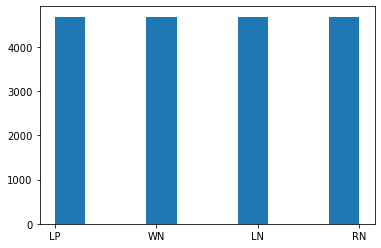

In [5]:
G = nx.read_gml('../Graphs/grafo_nedbit_C0006142.gml')

seed_genes          = pd.read_csv('../Datasets/C0006142_seed_genes.txt', header=None, sep=' ')
seed_genes.columns  = ["name", "GDA Score"]
seeds_list          = seed_genes["name"].values.tolist()

nedbit_scores = pd.read_csv('../Datasets/C0006142_features_Score.csv')

# Remove seed genes
nedbit_scores_not_seed = nedbit_scores[~nedbit_scores['name'].isin(seeds_list)]
print(nedbit_scores_not_seed.shape)

# Sort scores for quartile division
nedbit_scores_not_seed = nedbit_scores_not_seed.sort_values(by = "out", ascending = False)
pseudo_labels = pd.qcut(x = nedbit_scores_not_seed["out"], q = 4, labels = ["RN", "LN", "WN", "LP"])

plt.hist(pseudo_labels)
plt.show()

In [6]:
nedbit_scores_not_seed['label'] = pseudo_labels

nedbit_scores_seed = nedbit_scores[nedbit_scores['name'].isin(seeds_list)]
nedbit_scores_seed = nedbit_scores_seed.assign(label = 'P')

# Convert dataframe to dict for searching nodes and their labels
not_seed_labels = dict(zip(nedbit_scores_not_seed['name'], nedbit_scores_not_seed['label']))
seed_labels     = dict(zip(nedbit_scores_seed['name'], nedbit_scores_seed['label']))

labels_dict = {'P':0, 'LP': 1, 'WN': 2, 'LN': 3, 'RN': 4}
labels = []

for node in G:
    if node in not_seed_labels:
        labels.append(labels_dict[not_seed_labels[node]])
    else:
        labels.append(labels_dict[seed_labels[node]])

labels = np.asarray(labels)
len(labels)

19761

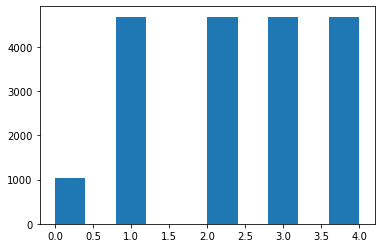

In [7]:
attributes = ['degree', 'ring', 'NetRank', 'NetShort', 'HeatDiff', 'InfoDiff']

dataset_with_nedbit = MyDataset(G, labels, attributes, num_classes=5)
data_with_nedbit = dataset_with_nedbit[0]

plt.hist(labels)
plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 829.0 Train: 67.92 Val: 68.63 Test: 68.42
FINAL
Train Accuracy: 67.92 ± 0.00%
Stopping Accuracy: 68.63 ± 0.00%
Test     Accuracy: 68.42 ± 0.00%
Steps: 2.98 ± 0.00
Epochs:  829.00 ± 0.00
Runtime: 500.5677 ± 0.0000



c:\Users\pmaur\miniconda3\envs\pytorch\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


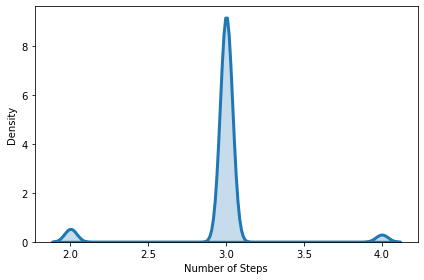

              precision    recall  f1-score   support

           0       0.05      0.19      0.08       154
           1       0.37      0.60      0.46       703
           2       0.29      0.23      0.25       702
           3       0.29      0.12      0.17       703
           4       0.59      0.37      0.45       702

    accuracy                           0.32      2964
   macro avg       0.32      0.30      0.28      2964
weighted avg       0.37      0.32      0.32      2964



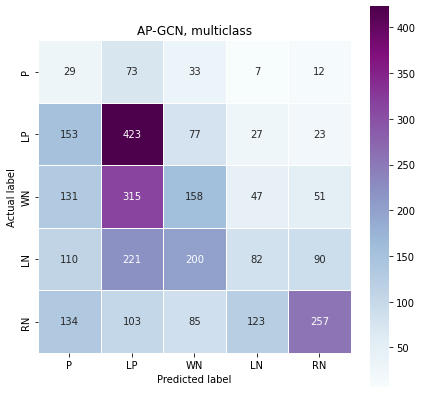

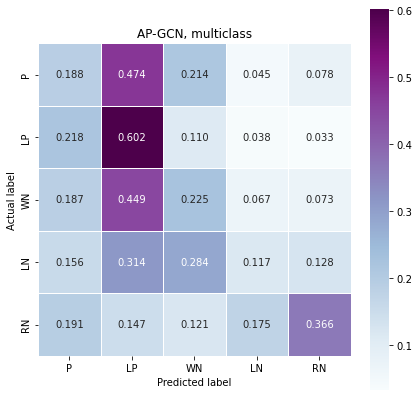

In [8]:
model = APGCN(dataset_with_nedbit, niter=10, prop_penalty=0.05, dropout=0.5)
pred = run(model.to(device), dataset_with_nedbit, test=True, max_epochs=5000, patience=100)
cm_print(data_with_nedbit, pred, title='AP-GCN, multiclass', classes=['P', 'LP', 'WN', 'LN', 'RN'])